# Number of Simulations vs. Pareto Ranks by Team

This notebook explores the number of simulations that were done by team and grouped by 
their experimental condition and plots them against their Pareto ranks.

In [29]:
import sys
import os.path

sys.path.append("../CommonModules") # go to parent dir/CommonModules

import Learning2019GTL.Globals as Globals
import Learning2019GTL.DataConnector as DataConnector

data_map = Globals.FileNameMaps()

TEAM_MAP = dict([[v,k] for k,v in data_map.CSV_MAP.items()])

DATA_FILE = os.path.expanduser("~/Learning2019Data/PostProcessingResults/TeamNumSimulationsByFile.csv")
DATA_FILE_PARETO = os.path.expanduser("~/Learning2019Data/PostProcessingResults/ParetoRankingByFile.csv")

import csv
import numpy as np

conditions = ['A - control (discuss conference) at beginning', 'B - strategy at beginning', 'D - strategy at mid']

class AnalyzedData:
    team_str   = ''
    unique_sims = -1
    total_sims  = -1
    condition  = ''
    pareto_ranks_coarse = -1 # one or more solutions to be the same rank
    pareto_ranks_granular = -1 # more solutions == better rank
    
analyzed_data = {} # empty dictionary

with open(DATA_FILE, 'r') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        team_file = row['File']
        team_str = TEAM_MAP[team_file]
        t = DataConnector.Team()
        condition = t.getCondition(team_str)[0]
        #print(row)
        #print(condition
        if team_str in analyzed_data.keys():
            datum = analyzed_data["team_str"]
        else:
            datum = AnalyzedData()
            analyzed_data[team_str] = datum
            datum.team_str = team_str
            
        datum.condition = condition
        datum.unique_sims = int(row[' UniqueSims'])
        datum.total_sims = int(row[' TotalSims'])
        


In [28]:
analyzed_data[team_str].total_sims

13

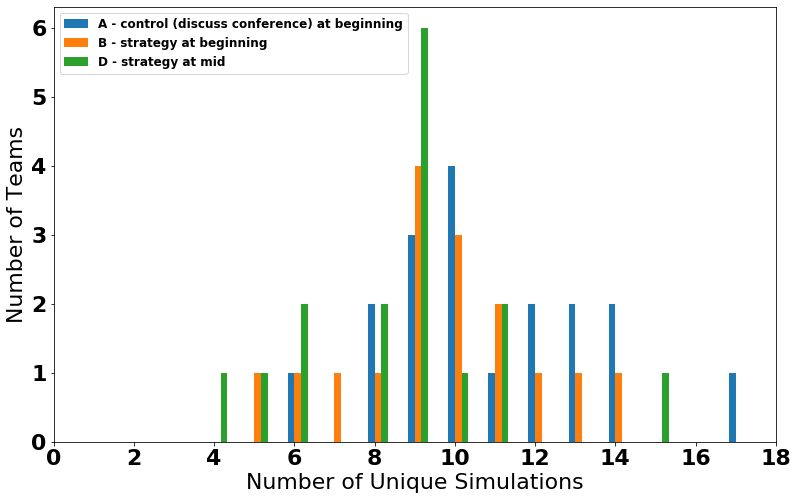

In [18]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt


font = {'family' : 'DejaVu Sans',
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

golden_ratio = np.array([1.61803398875, 1])
plt.figure(figsize=golden_ratio*8)

uniqueSimsA = np.array(uniqueSimsA)
uniqueSimsB = np.array(uniqueSimsB)
uniqueSimsD = np.array(uniqueSimsD)


plt.hist(uniqueSimsA-1/6, bins=np.arange(0, 18, 1/6), density=False)
plt.hist(uniqueSimsB+0/6, bins=np.arange(0, 18, 1/6), density=False)
plt.hist(uniqueSimsD+1/6, bins=np.arange(0, 18, 1/6), density=False)
plt.xlim([0, 18])
plt.legend(conditions, fontsize=12, loc=2)
plt.ylabel('Number of Teams')
plt.xlabel('Number of Unique Simulations')
plt.show()


In [9]:
print(max(uniqueSimsA))
print(max(uniqueSimsB))
print(max(uniqueSimsD))


17
14
15


In [21]:
DATA_FILE = os.path.expanduser("~/Learning2019Data/PostProcessingResults/ParetoRankingByFile.csv")

paretoRanksA = []
paretoRanksB = []
paretoRanksD = []

def getPRank(row):
    rank = -1
    for p in range(17):
        key = f'P{p}'
        if int(row[key]) > 0:
            rank = p
            break
            
    return rank

with open(DATA_FILE, 'r') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        team_file = row['File']
        team_str = TEAM_MAP[team_file]
        t = Team()
        condition = t.getClass(team_str)[0]
        rank = getPRank(row)
        print(f'{row["File"]}: {rank}, {condition}')
        #print(condition)
        if condition == 'A':
            paretoRanksA.append(rank)
            
        elif condition == 'B':
            paretoRanksB.append(rank)
            
        elif condition == 'D':
            paretoRanksD.append(rank)
            
paretoRanksA = np.array(paretoRanksA) + 1
paretoRanksB = np.array(paretoRanksB) + 1
paretoRanksD = np.array(paretoRanksD) + 1


Masie_20191028_133328_7_p3.csv: 0, D
Masie_20191028_080101_4_p3.csv: 0, A
Masie_20191029_090233_8_p3.csv: 4, D
Masie_20191029_065859_4_p3.csv: 1, B
Masie_20191029_065320_7_p3.csv: 1, D
Masie_20191028_133506_1_p3.csv: 0, A
Masie_20191029_131502_3_p3.csv: 1, D
Masie_20191029_144938_4_p3.csv: 2, B
Masie_20191029_090319_5_p3.csv: 1, D
Masie_20191028_104654_4_p3.csv: 1, B
Masie_20191029_102136_5_p3.csv: 1, A
Masie_20191029_090346_4_p3.csv: 0, B
Masie_20191029_090433_1_p3.csv: 1, B
Masie_20191028_104238_7_p3.csv: 0, D
Masie_20191028_133119_5_p3.csv: 0, A
Masie_20191029_144705_2_p3.csv: 0, B
Masie_20191028_145347_4_p3.csv: 0, B
Masie_20191028_080143_2_p3.csv: 1, A
Masie_20191029_090130_7_p3.csv: 0, A
Masie_20191029_131446_1_p3.csv: 1, D
Masie_20191029_144417_5_p3.csv: 1, A
Masie_20191028_145116_8_p3.csv: 0, A
Masie_20191028_080157_1_p3.csv: 1, A
Masie_20191028_133533_3_p3.csv: 1, A
Masie_20191029_090339_6_p3.csv: 0, D
Masie_20191028_133443_4_p3.csv: 1, A
Masie_20191028_145417_1_p3.csv: 0, B
M

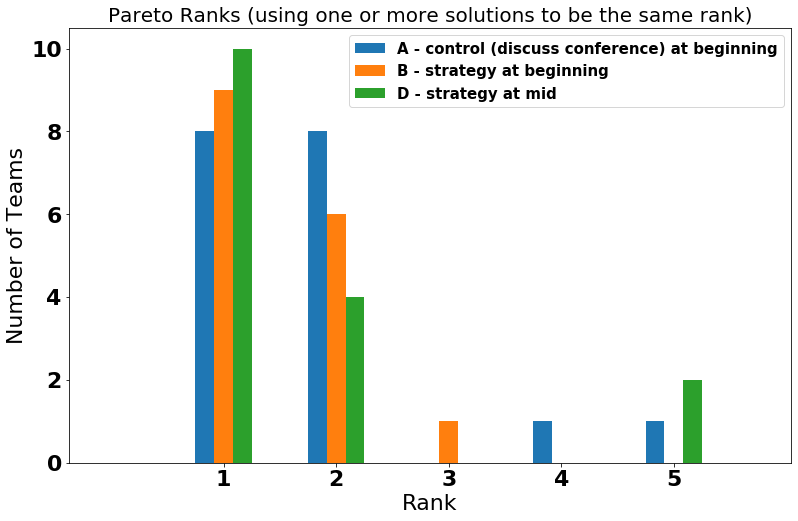

In [22]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

font = {'family' : 'DejaVu Sans',
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

golden_ratio = np.array([1.61803398875, 1])
plt.figure(figsize=golden_ratio*8)

plt.hist(paretoRanksA-1/6, bins=np.arange(0, 6, 1/6), align='left')
plt.hist(paretoRanksB+0/6, bins=np.arange(0, 6, 1/6), align='left')
plt.hist(paretoRanksD+1/6, bins=np.arange(0, 6, 1/6), align='left')
plt.xticks(np.arange(1, 6)) 
plt.xlabel('Rank')
plt.ylabel('Number of Teams')

plt.legend(conditions, loc=1, fontsize=15)
plt.title('Pareto Ranks (using one or more solutions to be the same rank)', fontsize=20)
plt.show()

In [23]:
print(conditions[0], paretoRanksA)
print(conditions[1], paretoRanksB)
print(conditions[2], paretoRanksD)

A - control (discuss conference) at beginning [1 1 2 1 2 1 2 1 2 2 2 2 1 4 5 1 1 2]
B - strategy at beginning [2 3 2 1 2 1 1 1 1 1 2 1 1 2 1 2]
D - strategy at mid [1 5 2 2 2 1 2 1 5 1 1 1 1 1 1 1]


In [24]:
DATA_FILE = os.path.expanduser("~/Learning2019Data/PostProcessingResults/ParetoRankingByFile.csv")

paretoRanksA = []
paretoRanksB = []
paretoRanksD = []

def getPRankWithNum(row):
    rank = -1
    for p in range(17):
        key = f'P{p}'
        val = int(row[key])
        if val > 0:
            rank = p + 1/(val + 1)
            break
            
    return rank

with open(DATA_FILE, 'r') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        team_file = row['File']
        team_str = TEAM_MAP[team_file]
        t = Team()
        condition = t.getClass(team_str)[0]
        rank = getPRankWithNum(row)
        print(f'{row["File"]}: {rank}, {condition}')
        #print(condition)
        if condition == 'A':
            paretoRanksA.append(rank)
            
        elif condition == 'B':
            paretoRanksB.append(rank)
            
        elif condition == 'D':
            paretoRanksD.append(rank)
            
print("Before ordinal rank")
allData = paretoRanksA + paretoRanksB + paretoRanksD
print(allData)
print(conditions[0], len(paretoRanksA), paretoRanksA)
print(conditions[1], len(paretoRanksB), paretoRanksB)
print(conditions[2], len(paretoRanksD), paretoRanksD)

import scipy.stats
rankedData = scipy.stats.rankdata(allData, method='dense')
paretoRanksA = rankedData[0:len(paretoRanksA)]
paretoRanksB = rankedData[len(paretoRanksA):len(paretoRanksA)+len(paretoRanksB)]
paretoRanksD = rankedData[len(paretoRanksA)+len(paretoRanksB):]

print("After ordinal rank")
print(rankedData)
print(conditions[0], len(paretoRanksA), paretoRanksA)
print(conditions[1], len(paretoRanksB), paretoRanksB)
print(conditions[2], len(paretoRanksD), paretoRanksD)


Masie_20191028_133328_7_p3.csv: 0.3333333333333333, D
Masie_20191028_080101_4_p3.csv: 0.5, A
Masie_20191029_090233_8_p3.csv: 4.333333333333333, D
Masie_20191029_065859_4_p3.csv: 1.3333333333333333, B
Masie_20191029_065320_7_p3.csv: 1.5, D
Masie_20191028_133506_1_p3.csv: 0.5, A
Masie_20191029_131502_3_p3.csv: 1.5, D
Masie_20191029_144938_4_p3.csv: 2.3333333333333335, B
Masie_20191029_090319_5_p3.csv: 1.2, D
Masie_20191028_104654_4_p3.csv: 1.5, B
Masie_20191029_102136_5_p3.csv: 1.5, A
Masie_20191029_090346_4_p3.csv: 0.3333333333333333, B
Masie_20191029_090433_1_p3.csv: 1.5, B
Masie_20191028_104238_7_p3.csv: 0.5, D
Masie_20191028_133119_5_p3.csv: 0.25, A
Masie_20191029_144705_2_p3.csv: 0.5, B
Masie_20191028_145347_4_p3.csv: 0.5, B
Masie_20191028_080143_2_p3.csv: 1.3333333333333333, A
Masie_20191029_090130_7_p3.csv: 0.5, A
Masie_20191029_131446_1_p3.csv: 1.25, D
Masie_20191029_144417_5_p3.csv: 1.25, A
Masie_20191028_145116_8_p3.csv: 0.5, A
Masie_20191028_080157_1_p3.csv: 1.5, A
Masie_20191

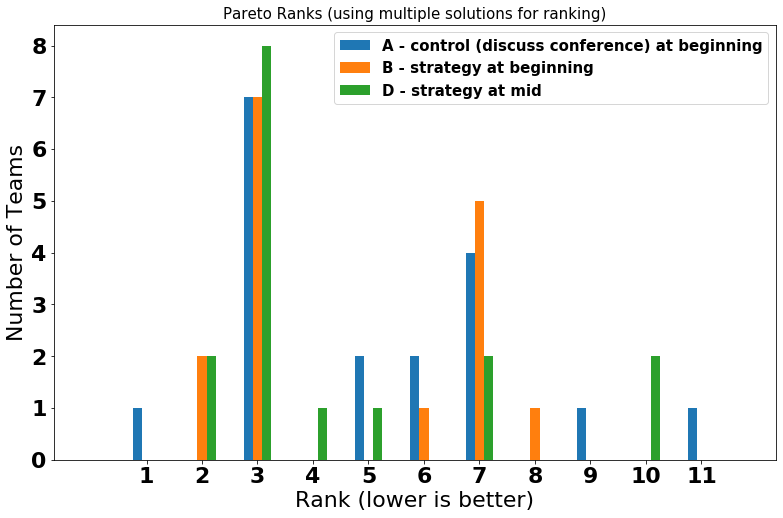

In [27]:
%matplotlib inline
import matplotlib.pyplot as plt

font = {'family' : 'DejaVu Sans',
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

golden_ratio = np.array([1.61803398875, 1])
plt.figure(figsize=golden_ratio*8)

plt.hist(paretoRanksA-1/6, bins=np.arange(0, 12, 1/6), align='left')
plt.hist(paretoRanksB+0/6, bins=np.arange(0, 12, 1/6), align='left')
plt.hist(paretoRanksD+1/6, bins=np.arange(0, 12, 1/6), align='left')
plt.xticks(np.arange(1, 12)) 
plt.xlabel('Rank (lower is better)')
plt.ylabel('Number of Teams')

plt.legend(conditions, loc=1, fontsize=15)
plt.title('Pareto Ranks (using multiple solutions for ranking)', fontsize=15)
plt.show()

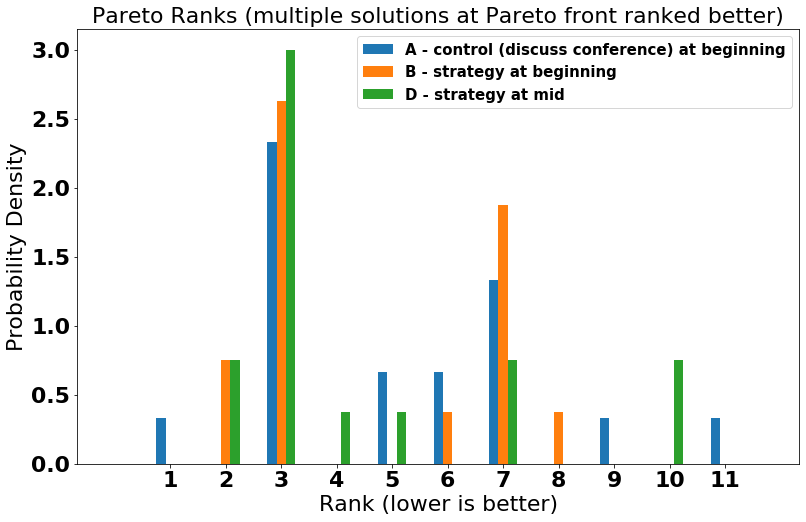

In [28]:
%matplotlib inline
import matplotlib.pyplot as plt

font = {'family' : 'DejaVu Sans',
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

golden_ratio = np.array([1.61803398875, 1])
plt.figure(figsize=golden_ratio*8)

plt.hist(paretoRanksA-1/6, bins=np.arange(0, 12, 1/6), align='left', density=True)
plt.hist(paretoRanksB+0/6, bins=np.arange(0, 12, 1/6), align='left', density=True)
plt.hist(paretoRanksD+1/6, bins=np.arange(0, 12, 1/6), align='left', density=True)
plt.xticks(np.arange(1, 12)) 
plt.xlabel('Rank (lower is better)')
plt.ylabel('Probability Density')

plt.legend(conditions, loc=1, fontsize=15)
plt.title('Pareto Ranks (multiple solutions at Pareto front ranked better)', fontsize=22)
plt.show()

In [ ]:
print(f'{conditions[0]}\n(mean, std) = ({np.mean(paretoRanksA)}, {np.std(paretoRanksA)})\n')
print(f'{conditions[1]}\n(mean, std) = ({np.mean(paretoRanksB)}, {np.std(paretoRanksB)})\n')
print(f'{conditions[2]}\n(mean, std) = ({np.mean(paretoRanksD)}, {np.std(paretoRanksD)})\n')
paretoRanksBD = np.append(paretoRanksB, paretoRanksD)
print(f'{conditions[1]}, {conditions[2]}\n(mean, std) = ({np.mean(paretoRanksBD)}, {np.std(paretoRanksBD)})\n')

In [ ]:
t2, p2 = scipy.stats.ttest_ind(paretoRanksA,paretoRanksB)
print("t = " + str(t2))
print("p = " + str(p2))

In [ ]:
t2, p2 = scipy.stats.ttest_ind(paretoRanksA,paretoRanksD)
print("t = " + str(t2))
print("p = " + str(p2))

In [ ]:
t2, p2 = scipy.stats.ttest_ind(paretoRanksB,paretoRanksD)
print("t = " + str(t2))
print("p = " + str(p2))

In [ ]:
t2, p2 = scipy.stats.ttest_ind(paretoRanksA,paretoRanksBD)
print("t = " + str(t2))
print("p = " + str(p2))

## Number of unique simulations verses pareto ranks

In [12]:
test_dict = {"test": 1, "b": 3}

In [18]:
test_dict.

AttributeError: 'dict' object has no attribute 'hasKey'